Evolving t1=1.0, t2=2.0: 100%|██████████| 400000/400000 [3:01:08<00:00, 36.80it/s]  


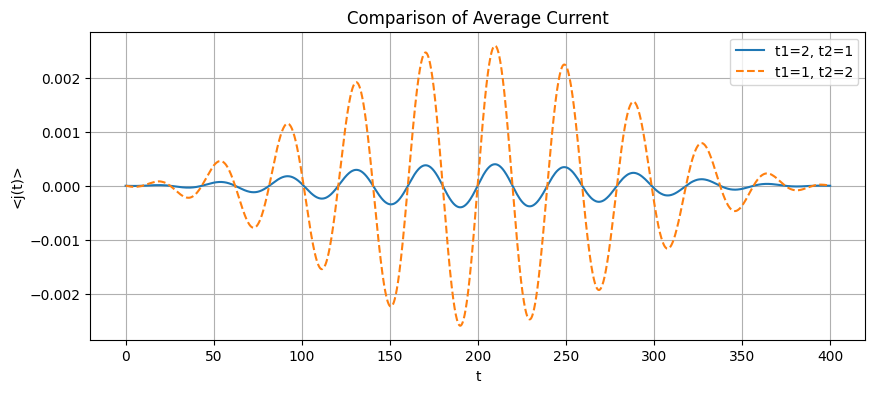

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def H_elements(k, At, t1, t2):
    denom = np.sqrt(t1**2 + t2**2 + 2*t1*t2*np.cos(k))
    Hpp = (t2**2*np.cos(At) + t1**2 + t1*t2*(np.cos(k) + np.cos(k - At))) / denom
    Hmm = -Hpp
    Hpm = 1j * t2 * (t2 * np.sin(At) + t1 * (np.sin(k) - np.sin(k - At))) / denom
    Hmp = np.conj(Hpm)
    return np.array([[Hpp, Hpm],[Hmp, Hmm]], dtype=complex)

def current_operator(k, At, t1, t2):
    denom = np.sqrt(t1**2 + t2**2 + 2*t1*t2*np.cos(k))
    # diagonal terms
    jpp =  t2 * (t2*np.sin(At) - t1*np.sin(k - At)) / denom
    jmm = -jpp
    # off-diagonal terms
    jpm = -1j * t2 * (t2*np.cos(At) + t1*np.cos(k - At)) / denom
    jmp = -jpm
    return np.array([[jpp, jpm],[jmp, jmm]], dtype=complex)

def A_t(t, A0=0.5, Nc=10, omega0=np.pi/(2*10)):
    return A0 * np.sin(omega0 * t) * (np.sin(omega0 * t / (2 * Nc)))**2

def run_sim(t1, t2, dt=0.001, Nk=251, A0=0.5, Nc=10):
    omega0 = np.pi/(2*Nc)
    dk = 2 * np.pi / Nk
    k_values = np.linspace(-np.pi, np.pi, Nk, endpoint=False)
    T = 2 * np.pi * Nc / omega0
    Nt = int(np.round(T / dt))
    # initial rho: lower band occupied
    rho0 = np.array([[0,0],[0,1]], dtype=complex)
    rho_k = np.tile(rho0, (Nk,1,1)).astype(complex)

    avg_current = np.zeros(Nt)
    for n in tqdm(range(Nt), desc=f"Evolving t1={t1}, t2={t2}"):
        t = n * dt
        At = A_t(t, A0=A0, Nc=Nc, omega0=omega0)
        j_total = 0.0
        for i, k in enumerate(k_values):
            H = H_elements(k, At, t1, t2)
            evals, evecs = np.linalg.eigh(H)
            U = evecs @ np.diag(np.exp(-1j * evals * dt)) @ evecs.conj().T
            rho_k[i] = U @ rho_k[i] @ U.conj().T
            J = current_operator(k, At, t1, t2)
            j_total += np.trace(J @ rho_k[i]).real * dk / (2*np.pi)
        avg_current[n] = j_total
    time = np.linspace(0, T, Nt)
    return time, avg_current

# Run both cases
time, j1 = run_sim(t1=2.0, t2=1.0)
_,   j2 = run_sim(t1=1.0, t2=2.0)

# Plot comparison
plt.figure(figsize=(10,4))
plt.plot(time, j1, label='t1=2, t2=1')
plt.plot(time, j2, label='t1=1, t2=2', linestyle='--')
plt.xlabel('t')
plt.ylabel('<j(t)>')
plt.legend()
plt.title('Comparison of Average Current')
plt.grid(True)
plt.show()

